In [1]:
import time
import json
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50
from torchvision.io import read_image
from torchvision.transforms import Resize, Compose, Normalize, Lambda
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from sklearn.model_selection import train_test_split

# CNN Backbone
class CNNBackbone(nn.Module):
    def __init__(self):
        super(CNNBackbone, self).__init__()
        self.feature_extractor = resnet50(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(self.feature_extractor.children())[:-2])

    def forward(self, x):
        x = self.feature_extractor(x)
        return x

# Transformer Model
class PoseTransformer(nn.Module):
    def __init__(self, num_keypoints, d_model=256, nhead=8, num_encoder_layers=6):
        super(PoseTransformer, self).__init__()
        self.d_model = d_model
        self.num_keypoints = num_keypoints
        self.keypoint_embedding = nn.Linear(2, d_model)
        cnn_output_size = 100352  # Fixed size based on flattened CNN output
        fusion_input_size = d_model * num_keypoints + cnn_output_size
        self.fusion_layer = nn.Linear(fusion_input_size, num_keypoints * d_model)
        encoder_layers = TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers=num_encoder_layers)
        self.pos_decoder = nn.Linear(d_model, 3)

    def forward(self, keypoints, cnn_features):
        keypoints = keypoints.view(-1, self.num_keypoints, 2)
        keypoint_embeddings = self.keypoint_embedding(keypoints)
        keypoint_embeddings = keypoint_embeddings.view(-1, self.d_model * self.num_keypoints)

        cnn_features = cnn_features.view(-1, 100352)  # Reshape to match the known flattened size

        combined_features = torch.cat((keypoint_embeddings, cnn_features), dim=1)
        combined_features = self.fusion_layer(combined_features)
        combined_features = combined_features.view(-1, self.num_keypoints, self.d_model)

        transformer_output = self.transformer_encoder(combined_features)
        output = self.pos_decoder(transformer_output)
        return output


class Keypoint3DModel(nn.Module):
    def __init__(self, num_keypoints):
        super(Keypoint3DModel, self).__init__()
        self.cnn_backbone = CNNBackbone()
        self.pose_transformer = PoseTransformer(num_keypoints)

    def forward(self, images, keypoints):
        cnn_features = self.cnn_backbone(images)
        cnn_features = torch.flatten(cnn_features, start_dim=1)
        output = self.pose_transformer(keypoints, cnn_features)
        return output


# Dataset Class
class MyDataset(Dataset):
    data_counter = 0
    
    def __init__(self, base_path, transform=None):
        self.base_path = base_path
        self.transform = transform
        self.filenames = [f.split('.')[0] for f in os.listdir(os.path.join(base_path, 'images'))]
        MyDataset.data_counter = 0

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        MyDataset.data_counter += 1
        total_data = len(self.filenames)
        print(f"Data loaded: {idx + 1} - {MyDataset.data_counter} / {total_data}")
        
        filename = self.filenames[idx]

        # Load image
        image_path = os.path.join(self.base_path, 'images', filename + '.png')
        image = read_image(image_path)
        if self.transform:
            image = self.transform(image)

        # Load 2D keypoints
        json_2d_path = os.path.join(self.base_path, 'mapping_2d', filename + '.json')
        with open(json_2d_path, 'r') as f:
            data_2d = json.load(f)

        # Convert keypoints to a tensor
        keypoints = torch.tensor([[kp['position']['x'], kp['position']['y']] for kp in data_2d['keypoints']], dtype=torch.float32)

        # Load 3D poses
        json_3d_path = os.path.join(self.base_path, 'mapping_3d', filename + '.json')
        with open(json_3d_path, 'r') as f:
            data_3d = json.load(f)

        # Convert 3D poses to a tensor
        poses = torch.tensor([[kp['position']['x'], kp['position']['y'], kp['position']['z']] for kp in data_3d['poses']], dtype=torch.float32)

        return image, keypoints, poses


# Loss Function and Optimizer
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        model.train()
        running_loss = 0.0
        for batch_idx, (images, keypoints, poses) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(images, keypoints)
            loss = criterion(outputs, poses)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if batch_idx % 10 == 0:  # Log every 10 batches
                print(f"    Batch {batch_idx}: Training Loss = {loss.item()}")

        average_training_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch + 1}, Average Training Loss: {average_training_loss}")
        epoch_end_time = time.time()
        print(f"Epoch {epoch + 1} completed in {(epoch_end_time - epoch_start_time):.2f} seconds.")

        # Evaluate model
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_idx, (images, keypoints, poses) in enumerate(val_loader):
                outputs = model(images, keypoints)
                loss = criterion(outputs, poses)
                val_loss += loss.item()
                if batch_idx % 10 == 0:  # Log every 10 batches
                    print(f"    Batch {batch_idx}: Validation Loss = {loss.item()}")

        average_validation_loss = val_loss / len(val_loader)
        print(f"Epoch {epoch + 1}, Average Validation Loss: {average_validation_loss}")


In [ ]:
# Example Usage
base_path = r"C:\Users\sakar\Semester Project\Spot Datasets\99 - Transformer 1"
transform = Compose([Resize((224, 224)),Lambda(lambda x: x.type(torch.FloatTensor)), Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
dataset = MyDataset(base_path, transform=transform)
train_set, val_set = train_test_split(dataset, test_size=0.2)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=4, shuffle=False)

num_keypoints = 13  # Adjust based on your actual number of keypoints
model = Keypoint3DModel(num_keypoints=num_keypoints)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the Model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30)
torch.save(model.state_dict(), 'poseformer.pth')

In [6]:
from torchvision.transforms import Resize, Compose, Normalize, ToTensor
from PIL import Image

# Inference
def load_image_and_keypoints(image_path, json_path, transform):
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    with open(json_path, 'r') as f:
        data_2d = json.load(f)
    keypoints = torch.tensor([[kp['position']['x'], kp['position']['y']] for kp in data_2d['keypoints']], dtype=torch.float32)
    return image, keypoints

def predict_3d_positions(model, image, keypoints_2d, device='cpu'):
    model.to(device)
    image = image.to(device)
    keypoints_2d = keypoints_2d.to(device)
    if len(image.shape) == 3:
        image = image.unsqueeze(0)
    if len(keypoints_2d.shape) == 2:
        keypoints_2d = keypoints_2d.unsqueeze(0)
    with torch.no_grad():
        predicted_3d_positions = model(image, keypoints_2d)
    return predicted_3d_positions

transform = Compose([Resize((224, 224)), ToTensor(), Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
image_path = "C:\\Users\\sakar\\Semester Project\\Spot Datasets\\13 - 2 Spots\\train\\images\\0.png"
json_path = "C:\\Users\\sakar\\Semester Project\\Spot Datasets\\13 - 2 Spots\\train\\mapping_2d\\0.json"
image, keypoints_2d = load_image_and_keypoints(image_path, json_path, transform)

model = Keypoint3DModel(num_keypoints=13)
model.load_state_dict(torch.load('trained_model.pth'))
model.eval()

predicted_3d_positions = predict_3d_positions(model, image, keypoints_2d)
print("Predicted 3D positions:", predicted_3d_positions)


Predicted 3D positions: tensor([[[-0.4658,  0.5505,  4.9346],
         [-0.4676,  0.5531,  4.9348],
         [-0.4664,  0.5502,  4.9354],
         [-0.4660,  0.5506,  4.9341],
         [-0.4662,  0.5490,  4.9357],
         [-0.4657,  0.5476,  4.9358],
         [-0.4648,  0.5445,  4.9355],
         [-0.4667,  0.5500,  4.9356],
         [-0.4673,  0.5504,  4.9343],
         [-0.4660,  0.5468,  4.9345],
         [-0.4659,  0.5523,  4.9339],
         [-0.4641,  0.5466,  4.9338],
         [-0.4666,  0.5519,  4.9338]]])


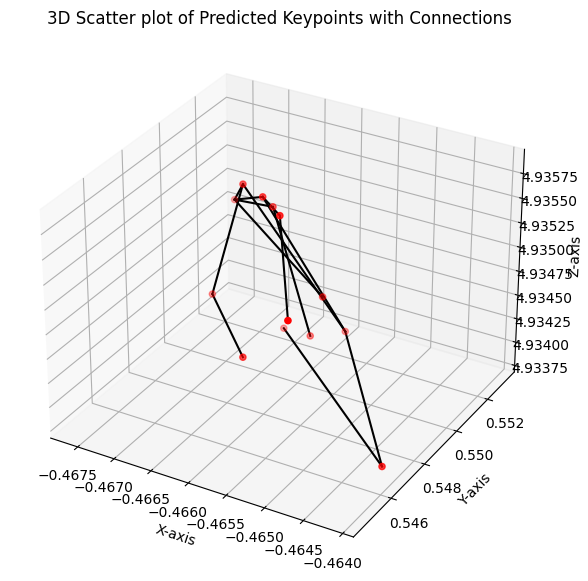

In [7]:
import matplotlib.pyplot as plt

# Assuming predicted_3d_positions is already defined
x = predicted_3d_positions[0, :, 0].numpy()
y = predicted_3d_positions[0, :, 1].numpy()
z = predicted_3d_positions[0, :, 2].numpy()

# Creating figure
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Creating scatter plot
ax.scatter(x, y, z, c='r', marker='o')

# Define pairs to connect
pairs = [(0, 1), (1, 4), (1, 7), (7, 10), (4, 10), (1, 2), (2, 3), (4, 5), (5, 6), (7, 8), (8, 9), (10, 11), (11, 12)]

# Draw lines between pairs
for start, end in pairs:
    ax.plot([x[start], x[end]], [y[start], y[end]], [z[start], z[end]], 'k-')  # 'k-' for black lines

# Setting labels
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

# Show plot
plt.title("3D Scatter plot of Predicted Keypoints with Connections")
plt.show()
